# pip install wordcloud

In [235]:
# pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


# import

In [236]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

import ast  # Thêm thư viện này để parse string thành list

from sklearn.feature_extraction.text import CountVectorizer # Tạo n-grams
from sklearn.feature_extraction.text import TfidfVectorizer # Tính TF-IDF

# UIT_VSMEC

## Đọc dữ liệu sau tiền xử lý

In [306]:
preprocessed_uit = pd.read_csv("../data/preprocessed_data/preprocessed_uit.csv", encoding='utf-8-sig', on_bad_lines='skip')

**Do dữ liệu đã được tiền xử lý và lưu dưới dạng chuỗi, ta cần chuyển đổi chúng trở lại thành danh sách từ**

In [307]:
# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
preprocessed_uit['Tokenized_Sentence'] = preprocessed_uit['Tokenized_Sentence'].apply(ast.literal_eval)

In [308]:
texts = preprocessed_uit['Tokenized_Sentence']

# Kiểm tra kiểu phần tử sau khi chuyển đổi
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'list'>
5 phần tử đầu tiên: [['mình', 'xin', 'bài', 'nhạc', 'tên', 'gì', 'ạ'], ['đáng', 'đời', 'con', 'quỷ', 'về', 'nhà', 'lôi', 'con', 'nhà', 'mày', 'đánh', 'phẫn_nộ'], ['lo', 'học', 'yêu', 'đương cười_lớn', 'gì', 'hay', 'thích', 'học sinh', 'học'], ['ước', 'gì', 'sau này', 'về', 'già', 'vẫn', 'có thể', 'cụ', 'cười'], ['mỗi', 'lần', 'video', 'con', 'cứ', 'coi', 'coi', 'hoài', 'cưng', 'con']]


## Các tham số thống kê của bộ dữ liệu

### Tổng quan 

In [309]:
print("===== TỔNG QUAN BỘ DỮ LIỆU =====")
preprocessed_uit.describe()

===== TỔNG QUAN BỘ DỮ LIỆU =====


Sentence    Emotion  \
count                                                6183       6183   
unique                                               6183          7   
top     dume lũ mất dạy . bố mẹ cho mày ăn học để dơ n...  Enjoyment   
freq                                                    1       1754   

       Tokenized_Sentence  
count                6183  
unique               6166  
top           [nguy hiểm]  
freq                    5

In [310]:
print("=== SỐ GIÁ TRỊ NULL ===")
print((preprocessed_uit.isna()).sum())

=== SỐ GIÁ TRỊ NULL ===
Sentence              0
Emotion               0
Tokenized_Sentence    0
dtype: int64


Nhận xét: 
- Bộ dữ liệu UIT_VSMEC sau tiền xử lý gồm 6183 mẫu, và 7 nhãn cảm xúc
- Trong đó, nhãn Enjoyment chiếm số lượng nhiều nhất 
- Bộ dữ liệu không có các mẫu trùng lặp và giá trị khuyết

### Phân bố số lượng các nhãn (Emotion)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\3447339324.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=preprocessed_uit,


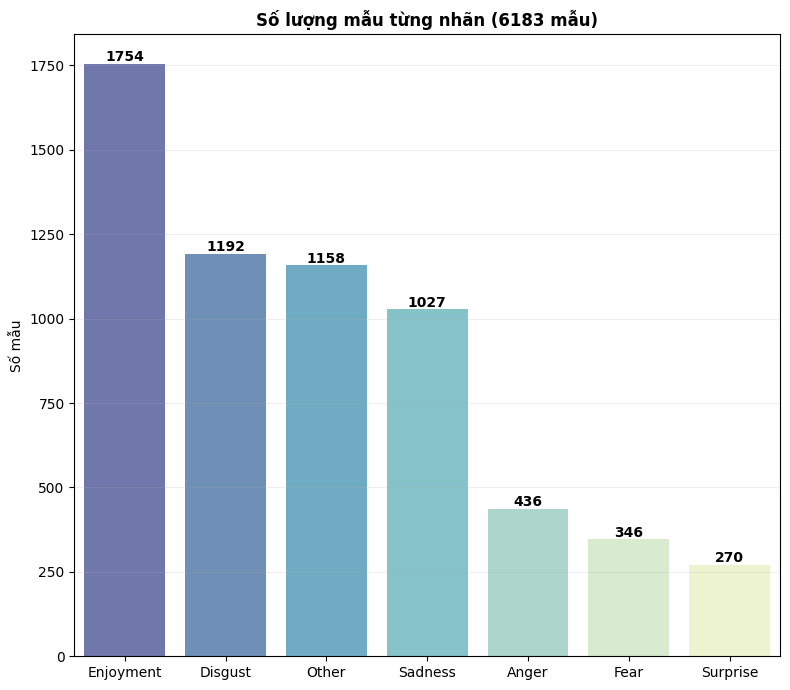

In [311]:
# Lấy danh sách nhãn đã sắp xếp theo số lượng giảm dần (từ tập gốc)
order_by_count = preprocessed_uit['Emotion'].value_counts().index

n_colors = len(order_by_count)
# Dùng 'YlGnBu_r' (_r là reverse) nếu muốn nhãn nhiều nhất màu đậm nhất.
consistent_colors = sns.color_palette('YlGnBu_r', n_colors)

# 1.2. Tạo từ điển ánh xạ: Tên Nhãn -> Màu cụ thể
# Kết quả sẽ giống như: {'Enjoyment': (r,g,b), 'Other': (r,g,b), ...}
color_mapping = dict(zip(order_by_count, consistent_colors))

fig, axes = plt.subplots(figsize=(8, 7))

sns.countplot(x='Emotion', data=preprocessed_uit, 
              order=order_by_count, palette=consistent_colors, ax=axes, alpha=0.7)
axes.set_title(f'Số lượng mẫu từng nhãn ({len(preprocessed_uit)} mẫu)', fontweight='bold')
axes.set_ylabel('Số mẫu')
axes.set_xlabel('')
# axes.tick_params(axis='x', rotation=20)
axes.grid(axis='y', alpha=0.2)

for i, p in enumerate(axes.patches):
        height = p.get_height()
        axes.text(p.get_x() + p.get_width() / 2., height + 8, 
                     f'{int(height)}', 
                     ha="center", fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

In [312]:
def analyze_class_imbalance(df, target_col='Emotion', beta=0.9999):
    """
    Độ mất cân bằng dữ liệu toàn diện.
    
    Args:
        df: DataFrame chứa dữ liệu
        target_col: Tên cột nhãn (ví dụ 'Emotion')
        beta: Tham số cho Effective Number (thường là 0.99, 0.999 hoặc 0.9999)
    """
    # 1. TÍNH TOÁN CÁC METRICS CƠ BẢN
    # ---------------------------------------------------------
    class_counts = df[target_col].value_counts().sort_values(ascending=False)
    total_samples = len(df)
    num_classes = len(class_counts)
    
    # Tạo DataFrame thống kê
    stats = pd.DataFrame({
        'Label': class_counts.index,
        'Count': class_counts.values
    })
    
    # Tính Tỷ lệ % (Percentage)
    stats['Percentage'] = (stats['Count'] / total_samples) * 100
    
    # Tính Imbalance Ratio (IR) = Số lượng lớp đa số / Số lượng lớp hiện tại
    # (IR càng cao chứng tỏ lớp đó càng bị lép vế so với lớp lớn nhất)
    majority_count = stats['Count'].max()
    stats['Imbalance Ratio (IR)'] = majority_count / stats['Count']
    
    # Tính Effective Number of Samples (En)
    # Công thức: (1 - beta^n) / (1 - beta)
    # Ý nghĩa: Đo lường lượng thông tin thực tế mà số lượng mẫu mang lại (bão hòa khi n lớn)
    stats['Effective Num'] = (1 - np.power(beta, stats['Count'])) / (1 - beta)
    
    # Hiển thị bảng thống kê
    print(f"MẤT CÂN BẰNG: {target_col}")
    print(f"Tổng số mẫu: {total_samples}")
    print(f"Số lượng nhãn: {num_classes}")
    print(f"Độ mất cân bằng toàn cục (Max/Min): {stats['Count'].max() / stats['Count'].min():.2f}")
    print("\nBảng chi tiết:")
    print(stats.to_string(index=False, float_format="%.2f"))
    print("-" * 80)

    # 2. VISUALIZATION (TRỰC QUAN HÓA)
    # ---------------------------------------------------------
    fig, axes = plt.subplots(figsize=(8, 7))
    
    # Biểu đồ 1: Pie Chart (Tỷ lệ phần trăm)
    # Tách miếng bé nhất ra một chút để dễ nhìn (explode)
    explode = [0.05 if c == stats['Count'].min() else 0 for c in stats['Count']]

    pie_colors = [color_mapping[label] for label in stats['Label']]
    
    axes.pie(stats['Count'], labels=stats['Label'], autopct='%1.1f%%', 
                startangle=140, colors=pie_colors, explode=explode,
                pctdistance=0.85, wedgeprops=dict(width=0.5))
    axes.set_title(f'Tỷ lệ phân bố các nhãn {target_col}', fontweight='bold', fontsize=14)
    
    # Thêm số tổng ở giữa biểu đồ tròn
    axes.text(0, 0, f"Total\n{total_samples}", ha='center', va='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

MẤT CÂN BẰNG: Emotion
Tổng số mẫu: 6183
Số lượng nhãn: 7
Độ mất cân bằng toàn cục (Max/Min): 6.50

Bảng chi tiết:
    Label  Count  Percentage  Imbalance Ratio (IR)  Effective Num
Enjoyment   1754       28.37                  1.00        1608.86
  Disgust   1192       19.28                  1.47        1123.75
    Other   1158       18.73                  1.51        1093.52
  Sadness   1027       16.61                  1.71         976.07
    Anger    436        7.05                  4.02         426.65
     Fear    346        5.60                  5.07         340.10
 Surprise    270        4.37                  6.50         266.40
--------------------------------------------------------------------------------


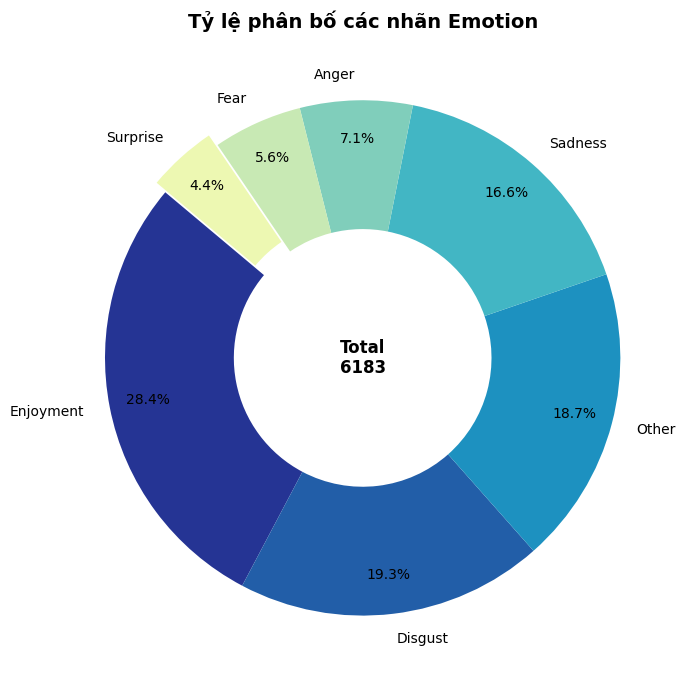

In [313]:
analyze_class_imbalance(preprocessed_uit, 'Emotion')

### Phân tích số lượng token trong một câu

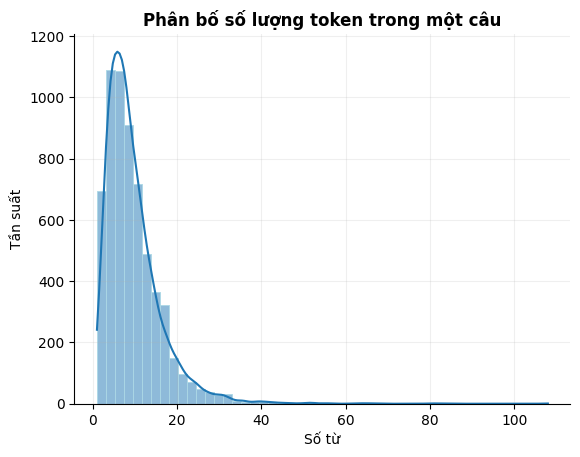

In [314]:
preprocessed_uit['tokens_length'] = preprocessed_uit['Tokenized_Sentence'].apply(lambda x: len(x))

sns.histplot(preprocessed_uit['tokens_length'], bins=50, edgecolor = 'lightblue', kde=True)    # bins: kc cách đều
sns.despine(top=True, right=True)
plt.title("Phân bố số lượng token trong một câu", fontweight = 'bold')
plt.xlabel("Số từ")
plt.ylabel("Tần suất")
plt.grid(alpha = 0.2)
plt.show()

In [315]:
print("THAM SỐ THỐNG KÊ CỘT tokens_length")
preprocessed_uit.describe()

THAM SỐ THỐNG KÊ CỘT tokens_length


tokens_length
count    6183.000000
mean        9.547307
std         6.783760
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max       108.000000

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\702278627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Emotion', y='tokens_length', data=preprocessed_uit, palette='Spectral')


<Axes: xlabel='Emotion', ylabel='tokens_length'>

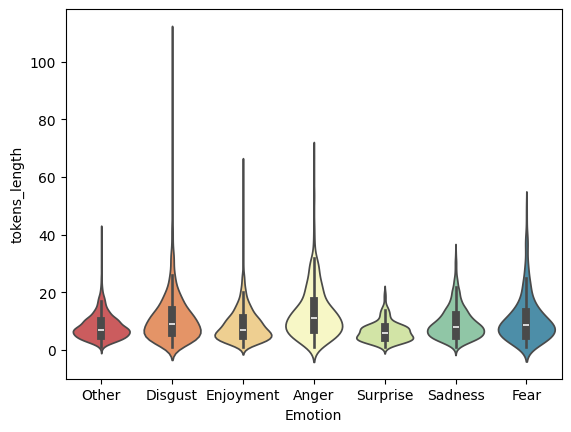

In [316]:
# Boxplot độ dài token theo từng nhãn
# sns.boxplot(x='Emotion', y='tokens_length', data=preprocessed_uit)
# Hoặc violin plot để thấy phân phối chi tiết hơn
sns.violinplot(x='Emotion', y='tokens_length', data=preprocessed_uit, palette='Spectral')

## Loại bỏ Outliner 

In [317]:
# # Tính Q1, Q3 và IQR
# Q1 = preprocessed_uit['tokens_length'].quantile(0.25)    
# Q3 = preprocessed_uit['tokens_length'].quantile(0.75)

# IQR = Q3 - Q1

# # Tính giới hạn trên, dưới
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
# print(f"Ngưỡng dưới: {lower_bound}, ngưỡng trên: {upper_bound}")

ngưỡng trên là 22.5, nhưng mà model vẫn có thể nhận biết tốt với số từ lớn hơn nx :<

nên hiện tại cmt đoạn này lại :<

In [318]:
# # Loại bỏ các mẫu có số token > upper_bound
# preprocessed_uit_filter = preprocessed_uit[preprocessed_uit['tokens_length'] <= upper_bound]
# print("Số lượng dòng loại bỏ sau khi loại bỏ outliner:", preprocessed_uit[preprocessed_uit['tokens_length'] > upper_bound].shape[0])
# print("Phân trăm dòng loại bỏ:", (preprocessed_uit[preprocessed_uit['tokens_length'] > upper_bound].shape[0] / preprocessed_uit.shape[0]) * 100, "%")
# print("Kích thước bộ dữ liệu sau khi loại bỏ outliner:", preprocessed_uit_filter.shape)

In [319]:
# # Vẽ lại phân bố sau loại bỏ 
# preprocessed_uit_filter['tokens_length'] = preprocessed_uit_filter['Tokenized_Sentence'].apply(lambda x: len(x))

# sns.histplot(preprocessed_uit_filter['tokens_length'], bins=50, edgecolor = 'lightblue', kde=True)    # bins: kc cách đều
# sns.despine(top=True, right=True)
# plt.title("Phân bố số lượng token ở các dòng sau khi loại outliner", fontweight = 'bold')
# plt.xlabel("Số từ")
# plt.ylabel("Tần suất")
# plt.grid(alpha = 0.2)
# plt.show()

In [320]:
# # 1. Chuẩn bị dữ liệu: Gán nhãn để phân biệt và gộp lại
# # Tạo bản sao nhẹ để không ảnh hưởng dữ liệu gốc
# df_before = preprocessed_uit[['Emotion']].copy()
# df_before['Trạng thái'] = 'Trước khi lọc'

# df_after = preprocessed_uit_filter[['Emotion']].copy()
# df_after['Trạng thái'] = 'Sau khi lọc'

# # Gộp 2 dataframe lại thành 1 (Long format)
# df_combined = pd.concat([df_before, df_after])

# # 2. Lấy thứ tự sắp xếp (theo số lượng từ tập gốc giảm dần)
# order_by_count = preprocessed_uit['Emotion'].value_counts().index

# # 3. Vẽ biểu đồ
# plt.figure(figsize=(10, 6))

# # Dùng 'hue' để tách cột theo trạng thái
# sns.countplot(x='Emotion', 
#               data=df_combined, 
#               hue='Trạng thái', 
#               order=order_by_count, 
#               palette={'Trước khi lọc': "#fefca5",'Sau khi lọc': "#8addf8"},
#               alpha=1)

# plt.title('So sánh phân bố nhãn cảm xúc Trước và Sau khi loại bỏ outlier dựa trên IQR và token_length', fontweight='bold', fontsize=14)
# plt.ylabel('Số mẫu')
# plt.xlabel('Emotion')
# plt.xticks(rotation=20)
# plt.grid(axis='y', alpha=0.2, linestyle='--')
# plt.legend(title=None) # Tắt tiêu đề của chú thích cho gọn

# plt.tight_layout()
# plt.show()

Nhận xét: tỉ lệ các nhãn không thay đổi quá nhiều sau khi loại bỏ outliner

## Trực quan hóa

In [321]:
preprocessed_uit.head(5)

Sentence    Emotion  \
0              cho mình xin bài nhạc tên là gì với ạ      Other   
1  cho đáng đời con quỷ . về nhà lôi con nhà mày ...    Disgust   
2  lo học đi . yêu đương cười_lớn gì hay lại thíc...    Disgust   
3   ước gì sau này về già vẫn có thể như cụ này cười  Enjoyment   
4  mỗi lần có video của con là cứ coi đi coi lại ...  Enjoyment   

                                  Tokenized_Sentence  tokens_length  
0                 [mình, xin, bài, nhạc, tên, gì, ạ]              7  
1  [đáng, đời, con, quỷ, về, nhà, lôi, con, nhà, ...             12  
2  [lo, học, yêu, đương cười_lớn, gì, hay, thích,...              9  
3  [ước, gì, sau này, về, già, vẫn, có thể, cụ, c...              9  
4  [mỗi, lần, video, con, cứ, coi, coi, hoài, cưn...             10

### Tần suất từ tổng thể

Ảnh này show ra sau bước tiền xử lý loại từ dừng

In [322]:
preprocessed_uit['Tokenized_Sentence']

0                      [mình, xin, bài, nhạc, tên, gì, ạ]
1       [đáng, đời, con, quỷ, về, nhà, lôi, con, nhà, ...
2       [lo, học, yêu, đương cười_lớn, gì, hay, thích,...
3       [ước, gì, sau này, về, già, vẫn, có thể, cụ, c...
4       [mỗi, lần, video, con, cứ, coi, coi, hoài, cưn...
                              ...                        
6178                                   [nhọc, lòng, buồn]
6179    [tao, muốn, làm bạn, tốt, anh em, tri kỉ, tụi,...
6180                     [cơm, tấm, ngoài, cũng, phẫn_nộ]
6181                                    [chất liệu, đỉnh]
6182    [dume, lũ, mất, dạy, bố mẹ, mày, ăn học, để, d...
Name: Tokenized_Sentence, Length: 6183, dtype: object

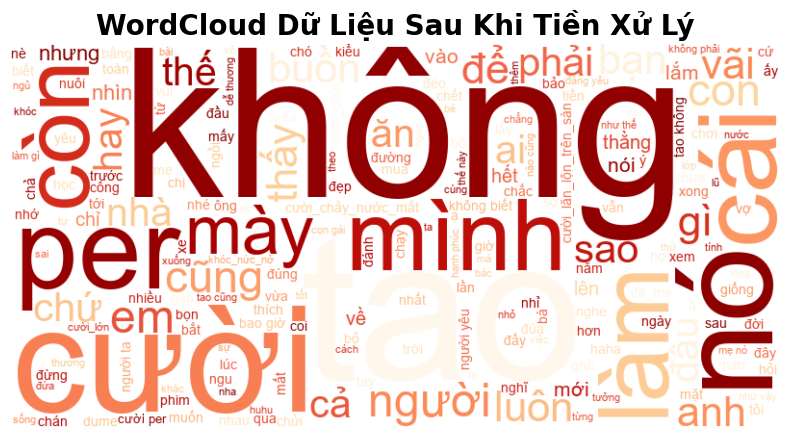

In [323]:
# Chuyển về dạng string 
def convert_to_list(text):
    if isinstance(text, str):
        try:
            return ast.literal_eval(text)
        except:
            return text.split()
    return text

preprocessed_uit['Tokenized_Sentence'] = preprocessed_uit['Tokenized_Sentence'].apply(convert_to_list)

# Join lại
all_words = " ".join([" ".join(tokens) if isinstance(tokens, list) else tokens 
                     for tokens in preprocessed_uit['Tokenized_Sentence']])
# Tạo WordCloud
wc = WordCloud(font_path='arial',
               background_color='white',
               width=800, height=400,
               colormap='OrRd').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Dữ Liệu Sau Khi Tiền Xử Lý",
          fontsize=20,
          fontweight='bold')
plt.show()

Nhận xét: Do enjoyment và icon nhiều nên chữ cười có tần suất xuất hiện nhiều nhất 

### Tần suất từ theo từng nhãn

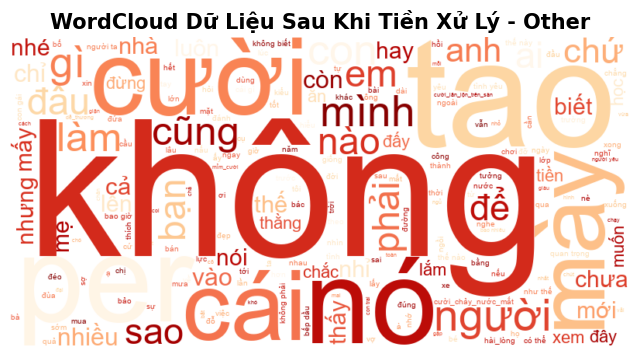

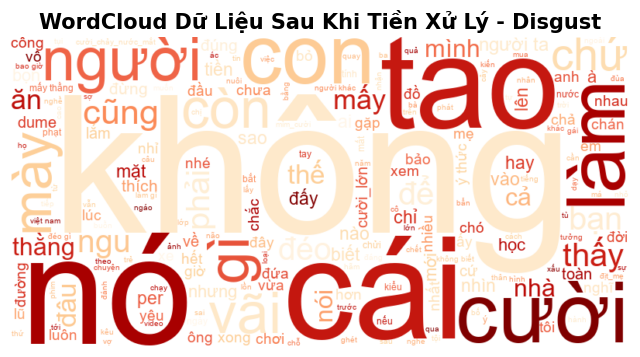

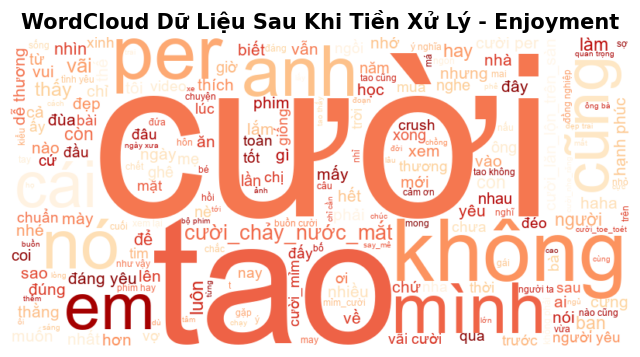

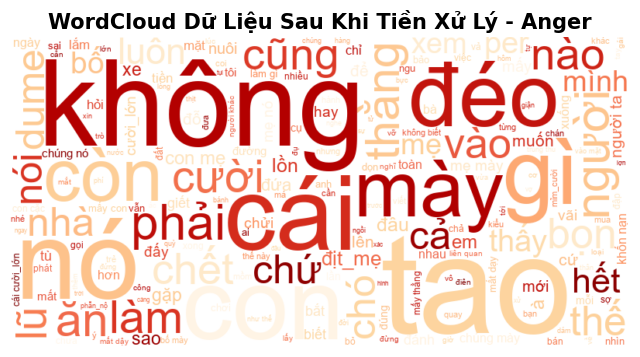

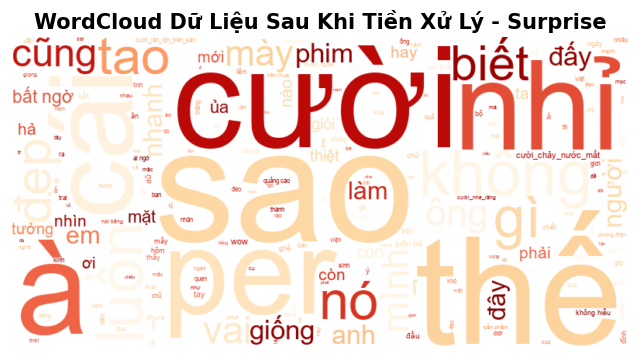

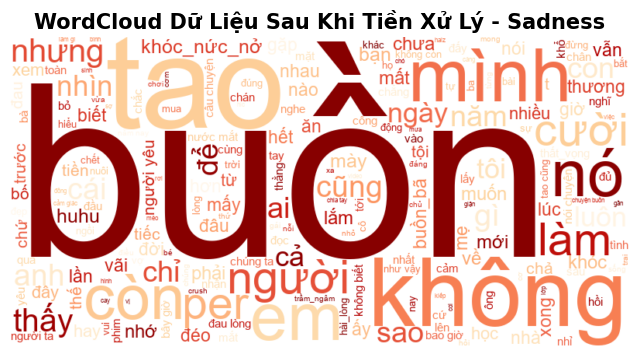

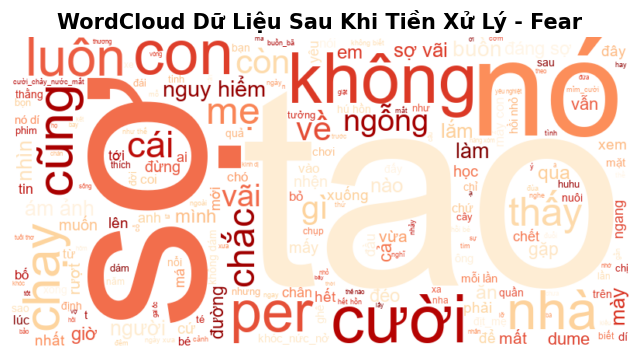

In [324]:
# WordCloud cho từng nhãn cảm xúc
emotions = preprocessed_uit['Emotion'].unique()

for idx, emotion in enumerate(emotions):
    emotion_data = preprocessed_uit[preprocessed_uit['Emotion'] == emotion]
    # Join lại
    all_words = " ".join([" ".join(tokens) if isinstance(tokens, list) else tokens 
                        for tokens in emotion_data['Tokenized_Sentence']])

    # Tạo WordCloud
    wc = WordCloud(font_path='arial',
                background_color='white',
                width=800, height=400,
                colormap='OrRd').generate(all_words)

    plt.figure(figsize=(8, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud Dữ Liệu Sau Khi Tiền Xử Lý - {emotion}",
            fontsize=15,
            fontweight='bold')
    plt.show()

### Phân bố số lượng token theo từng nhãn

--- THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN ---
            count       mean       std  min   25%   50%   75%    max
Emotion                                                             
Anger       436.0  12.788991  8.708377  1.0  7.00  11.0  17.0   67.0
Disgust    1192.0  11.310403  9.225105  1.0  5.75   9.0  14.0  108.0
Enjoyment  1754.0   8.697263  5.700364  1.0  5.00   7.0  11.0   64.0
Fear        346.0  10.768786  8.084249  1.0  5.00   8.5  13.0   50.0
Other      1158.0   8.246114  4.337417  1.0  5.00   7.0  10.0   41.0
Sadness    1027.0   9.444012  5.511244  1.0  5.00   8.0  12.0   34.0
Surprise    270.0   6.459259  3.388726  1.0  4.00   6.0   8.0   20.0


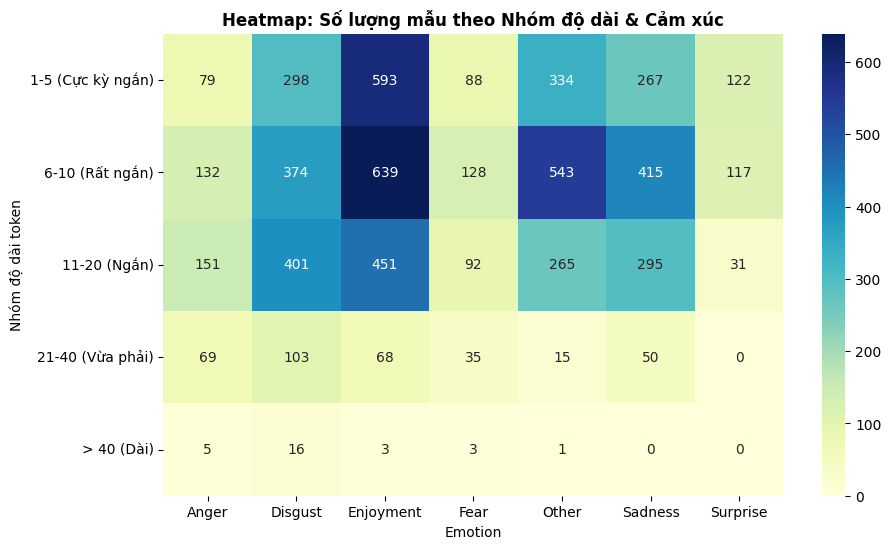

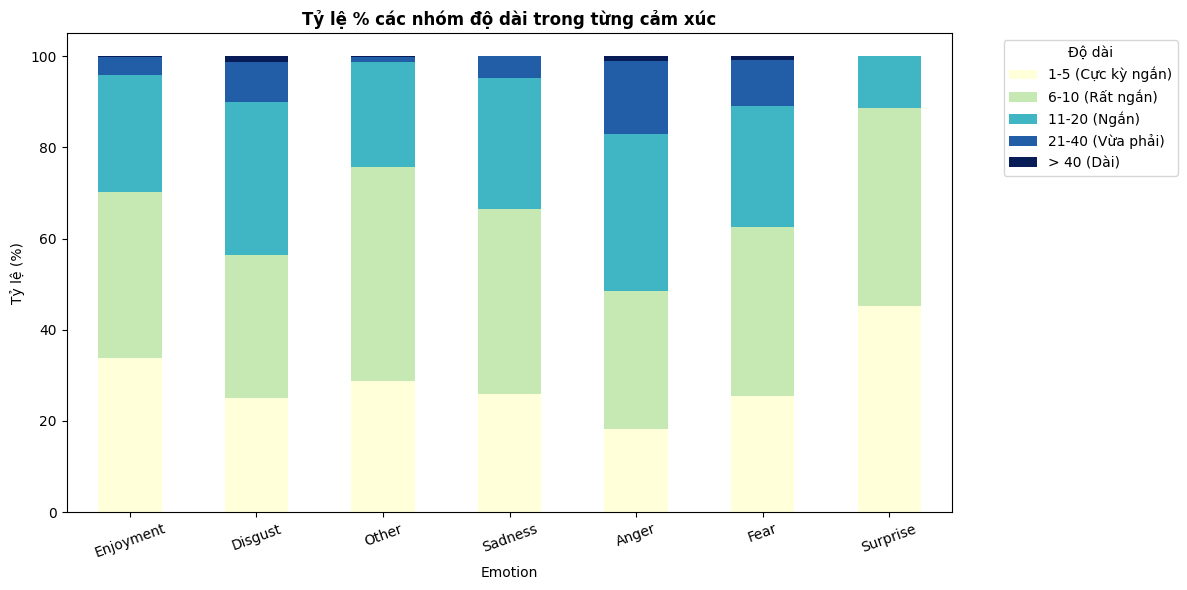

In [325]:
df = preprocessed_uit.copy()

# Lấy thứ tự nhãn theo số lượng
order_by_count = df['Emotion'].value_counts().index

# ==========================================
# BẢNG THỐNG KÊ CHI TIẾT (Describe)
# ==========================================
print("--- THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN ---")
stats = df.groupby('Emotion')['tokens_length'].describe()
print(stats)

# ==========================================
# PHÂN NHÓM ĐỘ DÀI - 5 nhóm từ Cực kỳ ngắn đến Rất dài
# ==========================================
# Định nghĩa các khoảng (bins) và nhãn (labels)
bins = [0, 5, 10, 20, 40, 1000]
labels = ['1-5 (Cực kỳ ngắn)', '6-10 (Rất ngắn)', '11-20 (Ngắn)', '21-40 (Vừa phải)', '> 40 (Dài)']

# Tạo cột nhóm độ dài
df['len_group'] = pd.cut(df['tokens_length'], bins=bins, labels=labels)

# Tính toán bảng Pivot: Đếm số lượng emotion trong từng nhóm độ dài
pivot_table = pd.crosstab(df['len_group'], df['Emotion'])

# Vẽ biểu đồ Heatmap để nhìn độ tập trung
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap: Số lượng mẫu theo Nhóm độ dài & Cảm xúc', fontweight='bold')
plt.xlabel('Emotion')
plt.ylabel('Nhóm độ dài token')
plt.show()

# Vẽ biểu đồ Stacked Bar để xem tỷ lệ %
pivot_percent = pd.crosstab(df['Emotion'], df['len_group'], normalize='index') * 100
pivot_percent = pivot_percent.loc[order_by_count] # Sắp xếp lại thứ tự

pivot_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='YlGnBu')
plt.title('Tỷ lệ % các nhóm độ dài trong từng cảm xúc', fontweight='bold')
plt.ylabel('Tỷ lệ (%)')
plt.xlabel('Emotion')
plt.legend(title='Độ dài', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

### Phân tích từ vựng: N-grams và TF-IDF keywords

#### N-grams: Bigram & Trigram

In [326]:
def plot_top_ngrams(corpus, n=2, top_k=10, title="Top n-grams"):
    """
    Hàm vẽ biểu đồ Top K n-grams phổ biến nhất
    n=2: Bigram, n=3: Trigram
    """
    # Khởi tạo vectorizer để đếm
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    # Tính tổng số lần xuất hiện của mỗi n-gram
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Sắp xếp giảm dần và lấy top k
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]
    
    # Chuyển thành DataFrame để vẽ
    df_ngram = pd.DataFrame(words_freq, columns=['Ngram', 'Count'])
    
    # Vẽ biểu đồ
    plt.figure(figsize=(7, 5))
    sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')
    plt.title(title, fontweight='bold')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-gram')
    plt.tight_layout()
    plt.show()


Phân tích cho nhãn: Other


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


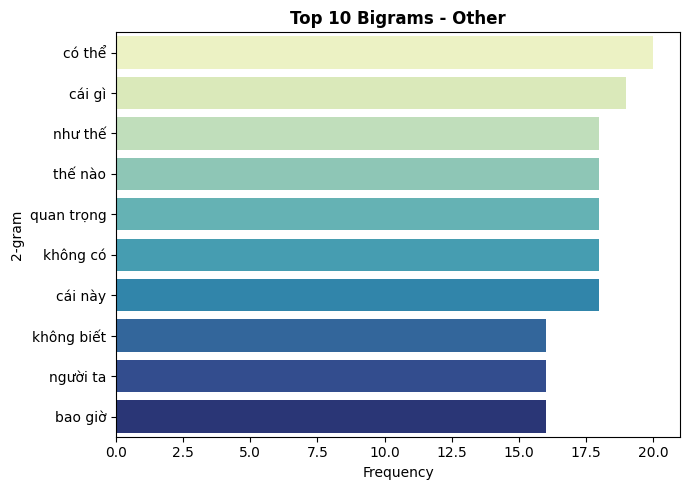

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


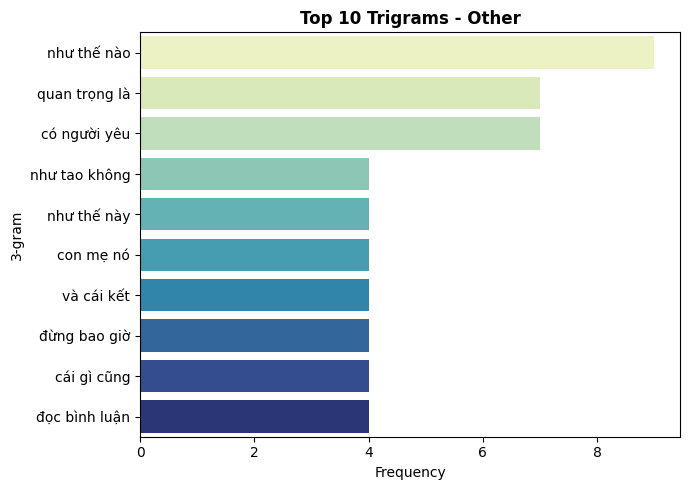


Phân tích cho nhãn: Disgust


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


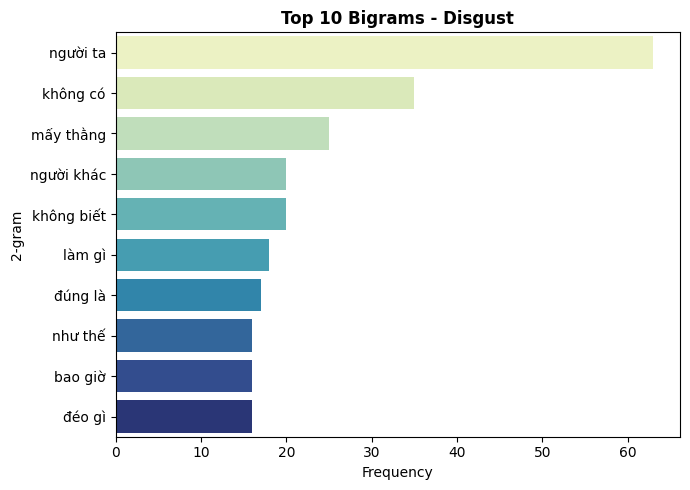

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


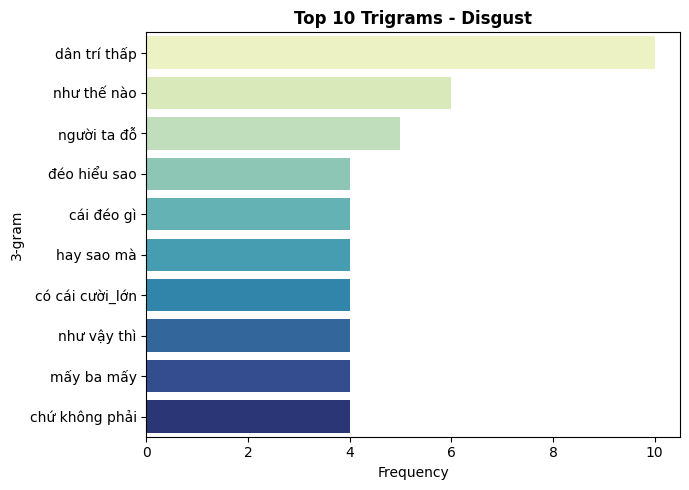


Phân tích cho nhãn: Enjoyment


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


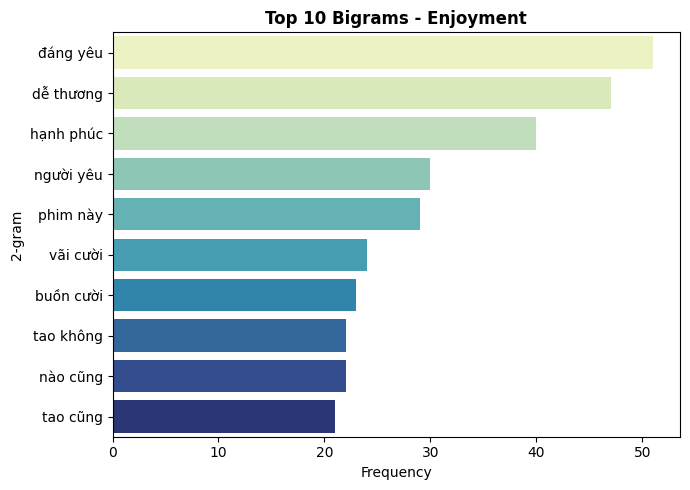

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


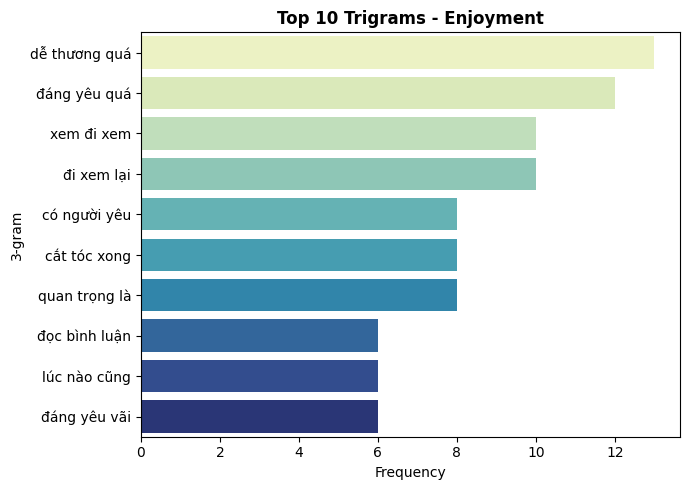


Phân tích cho nhãn: Anger


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


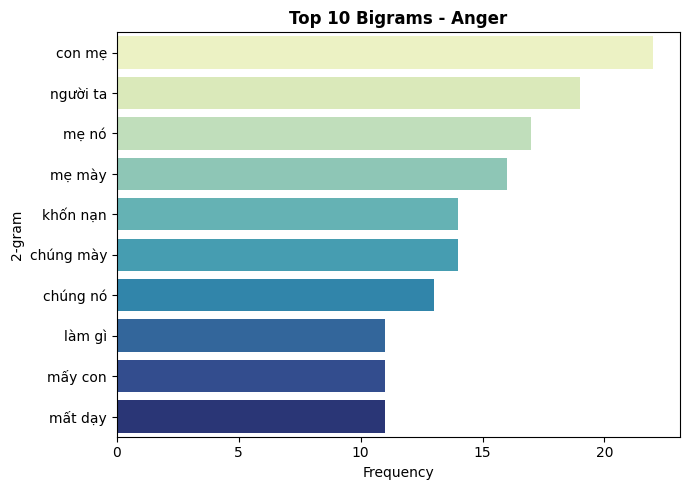

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


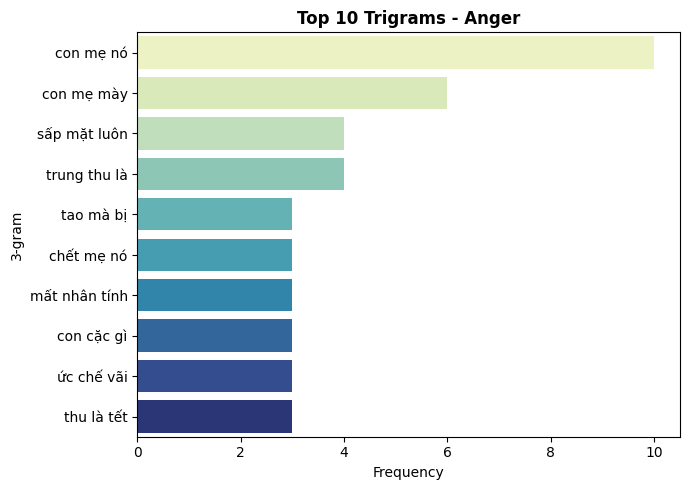


Phân tích cho nhãn: Surprise


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


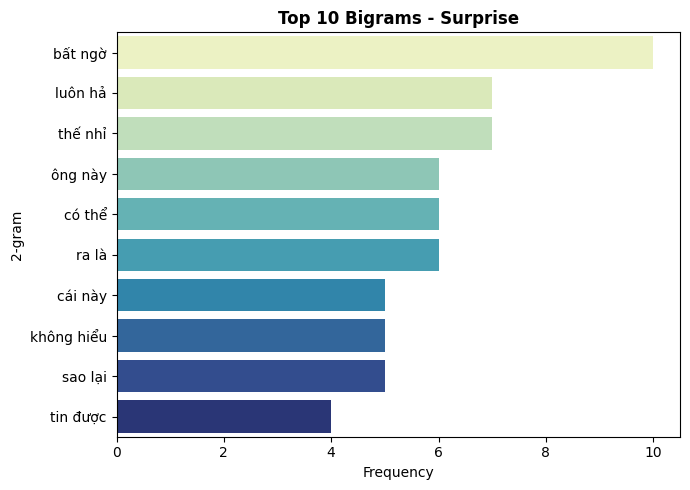

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


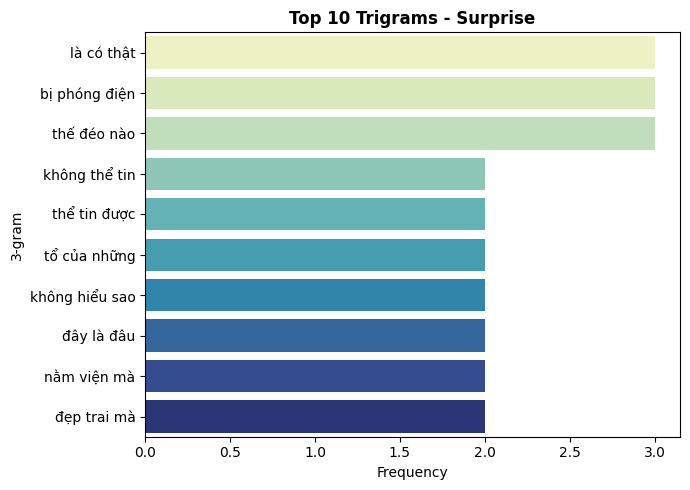


Phân tích cho nhãn: Sadness


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


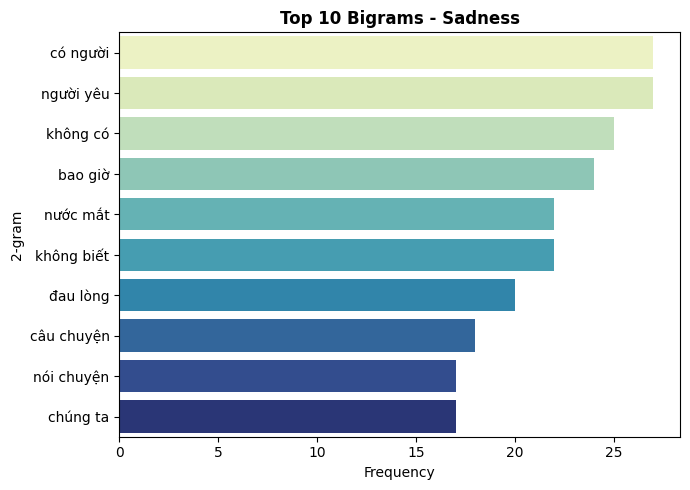

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


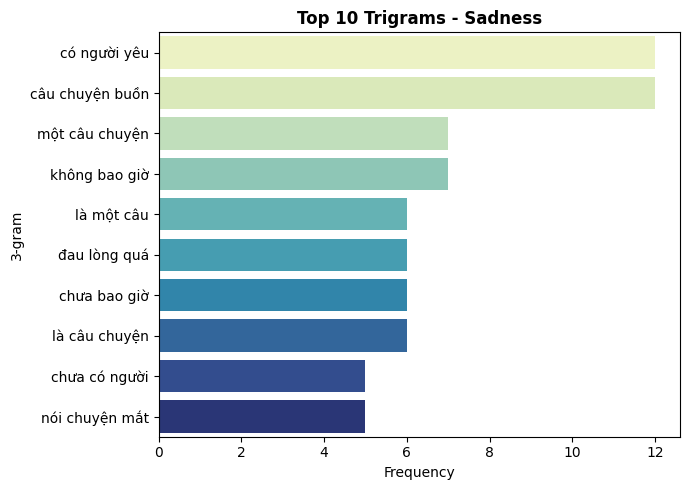


Phân tích cho nhãn: Fear


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


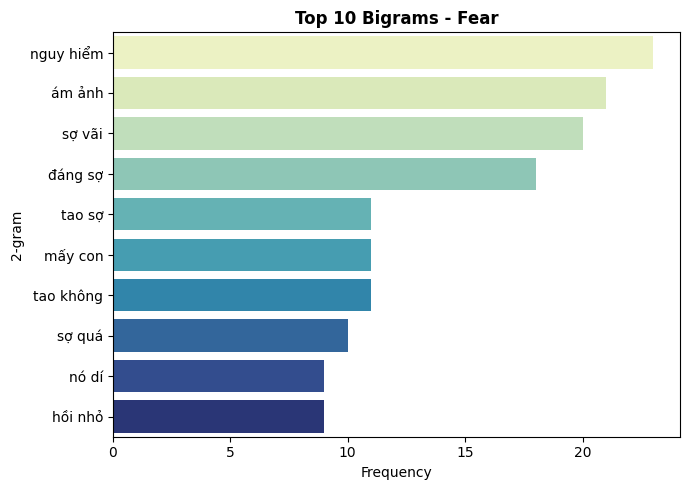

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


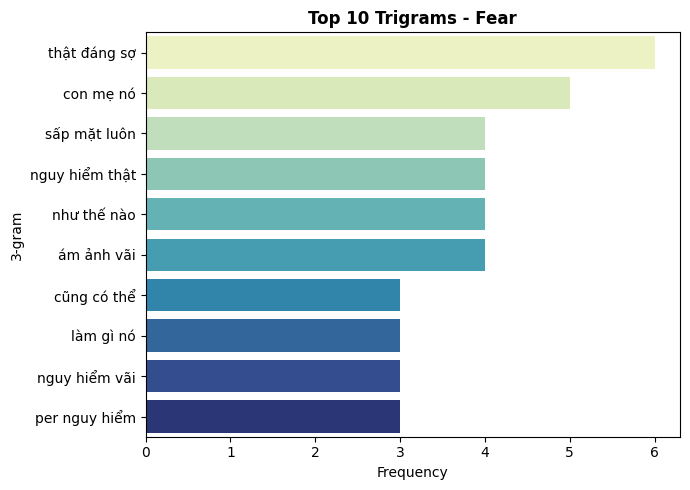

In [327]:
# chạy vòng lặp cho tất cả các nhãn
labels_to_check = df['Emotion'].unique() # đã có bảng df ở trên phần phân bố token

for label in labels_to_check:
    print(f"\nPhân tích cho nhãn: {label}")
    subset = df[df['Emotion'] == label]['Sentence'] # Thay 'Sentence' bằng tên cột văn bản đã xử lý của bạn
    
    # 1. Vẽ Bigram (2 từ)
    plot_top_ngrams(subset, n=2, top_k=10, title=f"Top 10 Bigrams - {label}")
    
    # 2. Vẽ Trigram (3 từ)
    plot_top_ngrams(subset, n=3, top_k=10, title=f"Top 10 Trigrams - {label}")

#### TF-IDF keysword

In [328]:
# 1. Gộp văn bản theo từng nhóm Emotion
grouped_df = df.groupby('Emotion')['Sentence'].apply(lambda x: ' '.join(x)).reset_index()

# 2. Tính TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000) # Thử cả unigram và bigram
tfidf_matrix = tfidf.fit_transform(grouped_df['Sentence'])
feature_names = tfidf.get_feature_names_out()

# 3. Hàm lấy top keywords theo điểm TF-IDF
def get_top_tfidf_keywords(row_idx, top_n=10):
    row_data = tfidf_matrix[row_idx]
    # Chuyển về dạng dense array để xử lý
    row_data = row_data.toarray().flatten()
    # Lấy index của top n điểm cao nhất
    top_indices = row_data.argsort()[-top_n:][::-1]
    
    top_keywords = [(feature_names[i], row_data[i]) for i in top_indices]
    return top_keywords

# 4. Hiển thị kết quả
print("--- TOP TỪ KHÓA ĐẶC TRƯNG (TF-IDF) CHO TỪNG NHÃN ---")
for idx, row in grouped_df.iterrows():
    emotion = row['Emotion']
    keywords = get_top_tfidf_keywords(idx, top_n=5)
    print(f"\nLabel: {emotion.upper()}")
    for kw, score in keywords:
        print(f"  - {kw}: {score:.4f}")

--- TOP TỪ KHÓA ĐẶC TRƯNG (TF-IDF) CHO TỪNG NHÃN ---

Label: ANGER
  - tao: 0.2924
  - nó: 0.2440
  - không: 0.2343
  - con: 0.2324
  - cho: 0.2111

Label: DISGUST
  - không: 0.2639
  - có: 0.2433
  - là: 0.2271
  - mà: 0.2262
  - nó: 0.2074

Label: ENJOYMENT
  - cười: 0.3938
  - tao: 0.2366
  - là: 0.2160
  - không: 0.2137
  - có: 0.2053

Label: FEAR
  - tao: 0.3965
  - sợ: 0.3476
  - nó: 0.2200
  - không: 0.2091
  - đi: 0.1955

Label: OTHER
  - không: 0.3268
  - có: 0.2766
  - là: 0.2743
  - thì: 0.1844
  - tao: 0.1739

Label: SADNESS
  - không: 0.2878
  - buồn: 0.2800
  - tao: 0.2533
  - có: 0.2122
  - mà: 0.2011

Label: SURPRISE
  - này: 0.3048
  - sao: 0.2814
  - vậy: 0.2462
  - thế: 0.2404
  - cười: 0.2110


# HUS_FB

## Đọc dữ liệu sau tiền xử lý

In [329]:
preprocessed_hus_fb = pd.read_csv("../data/preprocessed_data/preprocessed_hus_fb.csv", encoding='utf-8-sig', on_bad_lines='skip')

**Do dữ liệu đã được tiền xử lý và lưu dưới dạng chuỗi, ta cần chuyển đổi chúng trở lại thành danh sách từ**

In [330]:
# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
preprocessed_hus_fb['Tokenized_Sentence'] = preprocessed_hus_fb['Tokenized_Sentence'].apply(ast.literal_eval)

In [331]:
texts = preprocessed_hus_fb['Tokenized_Sentence']

# Kiểm tra kiểu phần tử sau khi chuyển đổi
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'list'>
5 phần tử đầu tiên: [['xin lỗi', 'chứ', 'loại', 'tôi', 'đéo', 'bao giờ', 'chơi', 'lần', '2', 'éo', 'hiểu', 'vui', 'gì', 'giỡn', 'gì', 'tới', 'lúc', '3', 'mặt', '1', 'lời', 'con', 'nói xấu', 'nó', 'đánh', 'mình', 'chắc', 'nhỏ', 'cũng', 'đứng', 'cười'], ['sợ', 'đánh', 'đừng', 'nói', 'cười'], ['sợ', 'đừng', 'nói', 'cười', 'bản lĩnh', 'cái', 'thằng', 'đàn ông', 'nói', 'chịu'], ['chắc', 'cuộc đời', 'mày', 'chưa', 'bao giờ', 'nói xấu', 'ai', 'chứ', 'vô chùa', 'ta', 'nói', 'không', 'biết', 'phải', 'lạy', 'ai', 'luôn', 'yêu_thương'], ['biết', 'nhưng', 'cái', 'mỏ', 'nó', 'giật', 'lắm', 'mày', 'cười_lăn_lộn_trên_sàn', 'chúng nó', 'cũng', 'nói xấu', 'tôi', 'qua', 'toại lòng', 'nhau', 'haha']]


## Các tham số thống kê của bộ dữ liệu

### Tổng quan 

In [332]:
print("===== TỔNG QUAN BỘ DỮ LIỆU =====")
preprocessed_hus_fb.describe()

===== TỔNG QUAN BỘ DỮ LIỆU =====


Sentence    Emotion  \
count                                                4521       4521   
unique                                               4521          7   
top     đảm bảo an sinh xã hội công bằng cho tất cả mọ...  Enjoyment   
freq                                                    1       1756   

       Tokenized_Sentence  
count                4521  
unique               4497  
top           [dễ thương]  
freq                    6

In [333]:
print("=== SỐ GIÁ TRỊ NULL ===")
print((preprocessed_hus_fb.isna()).sum())

=== SỐ GIÁ TRỊ NULL ===
Sentence              0
Emotion               0
Tokenized_Sentence    0
dtype: int64


Nhận xét: 
- Bộ dữ liệu HUS_FB sau tiền xử lý gồm 4521 mẫu, và 7 nhãn cảm xúc
- Trong đó, nhãn Enjoyment chiếm số lượng nhiều nhất 
- Bộ dữ liệu không có các mẫu trùng lặp và giá trị khuyết

### Phân bố số lượng các nhãn (Emotion)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\3749203535.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=preprocessed_uit,


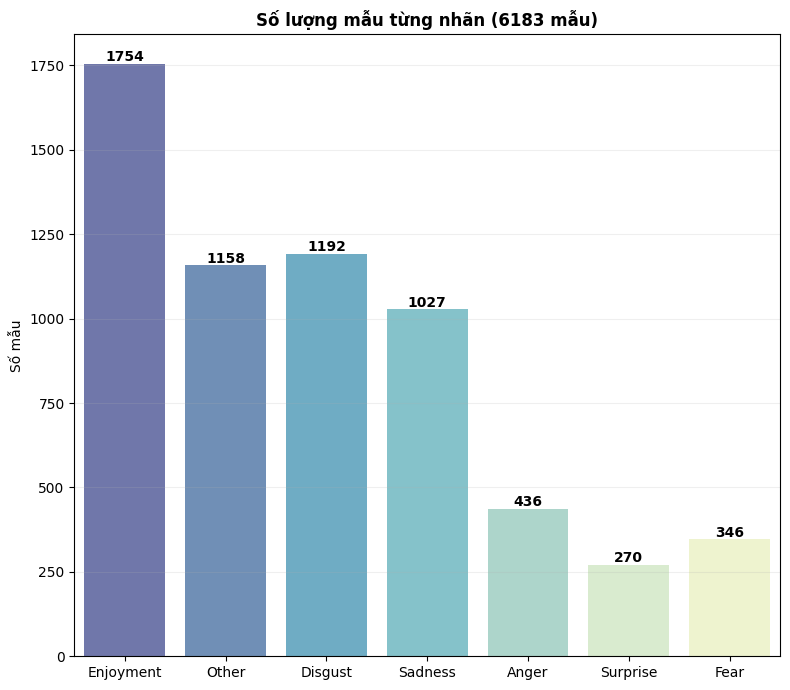

In [334]:
# Lấy danh sách nhãn đã sắp xếp theo số lượng giảm dần (từ tập gốc)
order_by_count = preprocessed_hus_fb['Emotion'].value_counts().index

n_colors = len(order_by_count)
# Dùng 'YlGnBu_r' (_r là reverse) nếu muốn nhãn nhiều nhất màu đậm nhất.
consistent_colors = sns.color_palette('YlGnBu_r', n_colors)

# 1.2. Tạo từ điển ánh xạ: Tên Nhãn -> Màu cụ thể
# Kết quả sẽ giống như: {'Enjoyment': (r,g,b), 'Other': (r,g,b), ...}
color_mapping = dict(zip(order_by_count, consistent_colors))

fig, axes = plt.subplots(figsize=(8, 7))

sns.countplot(x='Emotion', data=preprocessed_uit, 
              order=order_by_count, palette=consistent_colors, ax=axes, alpha=0.7)
axes.set_title(f'Số lượng mẫu từng nhãn ({len(preprocessed_uit)} mẫu)', fontweight='bold')
axes.set_ylabel('Số mẫu')
axes.set_xlabel('')
# axes.tick_params(axis='x', rotation=20)
axes.grid(axis='y', alpha=0.2)

for i, p in enumerate(axes.patches):
        height = p.get_height()
        axes.text(p.get_x() + p.get_width() / 2., height + 8, 
                     f'{int(height)}', 
                     ha="center", fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

MẤT CÂN BẰNG: Emotion
Tổng số mẫu: 4521
Số lượng nhãn: 7
Độ mất cân bằng toàn cục (Max/Min): 14.28

Bảng chi tiết:
    Label  Count  Percentage  Imbalance Ratio (IR)  Effective Num
Enjoyment   1756       38.84                  1.00        1610.54
    Other    860       19.02                  2.04         824.10
  Disgust    616       13.63                  2.85         597.44
  Sadness    445        9.84                  3.95         435.27
    Anger    428        9.47                  4.10         418.99
 Surprise    293        6.48                  5.99         288.76
     Fear    123        2.72                 14.28         122.25
--------------------------------------------------------------------------------


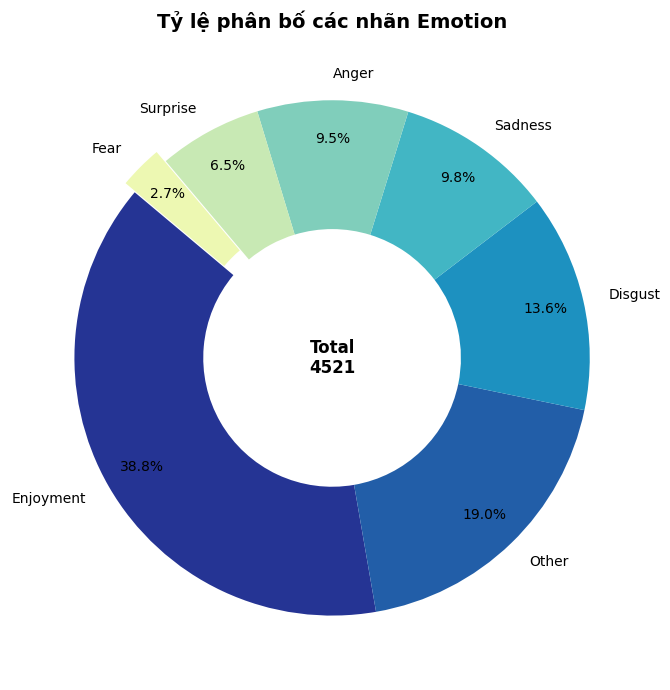

In [335]:
analyze_class_imbalance(preprocessed_hus_fb, 'Emotion')

### Phân tích số lượng token trong một câu

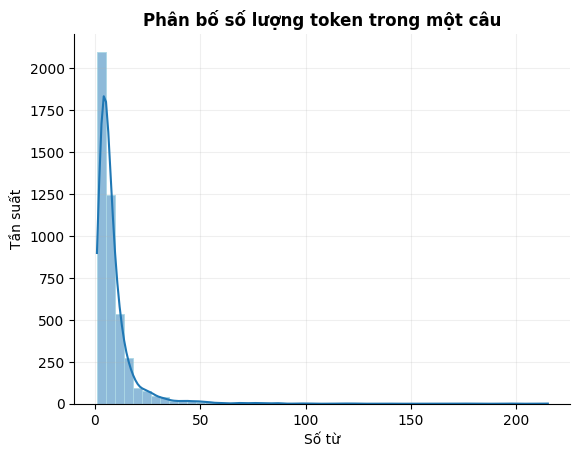

In [336]:
preprocessed_hus_fb['tokens_length'] = preprocessed_hus_fb['Tokenized_Sentence'].apply(lambda x: len(x))

sns.histplot(preprocessed_hus_fb['tokens_length'], bins=50, edgecolor = 'lightblue', kde=True)    # bins: kc cách đều
sns.despine(top=True, right=True)
plt.title("Phân bố số lượng token trong một câu", fontweight = 'bold')
plt.xlabel("Số từ")
plt.ylabel("Tần suất")
plt.grid(alpha = 0.2)
plt.show()

In [337]:
print("THAM SỐ THỐNG KÊ CỘT tokens_length")
preprocessed_hus_fb.describe()

THAM SỐ THỐNG KÊ CỘT tokens_length


tokens_length
count    4521.000000
mean        8.792081
std        11.374873
min         1.000000
25%         4.000000
50%         6.000000
75%        10.000000
max       215.000000

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\1213869001.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Emotion', y='tokens_length', data=preprocessed_hus_fb, palette='Spectral')


<Axes: xlabel='Emotion', ylabel='tokens_length'>

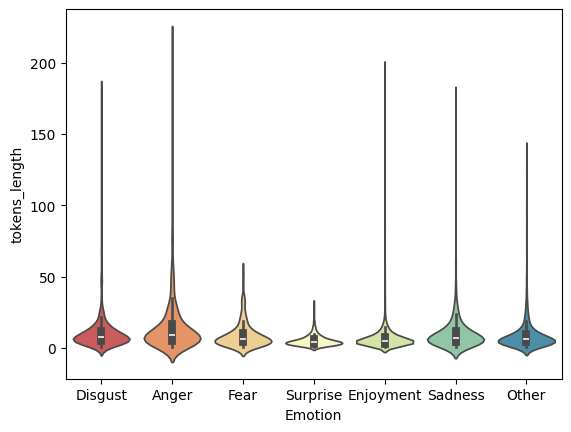

In [338]:
# Boxplot độ dài token theo từng nhãn
# sns.boxplot(x='Emotion', y='tokens_length', data=preprocessed_hus_fb)
# Hoặc violin plot để thấy phân phối chi tiết hơn
sns.violinplot(x='Emotion', y='tokens_length', data=preprocessed_hus_fb, palette='Spectral')

## Loại bỏ Outliner 

In [339]:
# Tính Q1, Q3 và IQR
Q1 = preprocessed_hus_fb['tokens_length'].quantile(0.25)    
Q3 = preprocessed_hus_fb['tokens_length'].quantile(0.75)

IQR = Q3 - Q1

# Tính giới hạn trên, dưới
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
print(f"Ngưỡng dưới: {lower_bound}, ngưỡng trên: {upper_bound}")

Q1 = 4.0, Q3 = 10.0, IQR = 6.0
Ngưỡng dưới: -5.0, ngưỡng trên: 19.0


ngưỡng trên là 19, nhưng mà model vẫn có thể nhận biết tốt với số từ lớn hơn nx :<

nên hiện tại cmt đoạn này lại :<

In [340]:
# # Loại bỏ các mẫu có số token > upper_bound
# preprocessed_uit_filter = preprocessed_uit[preprocessed_uit['tokens_length'] <= upper_bound]
# print("Số lượng dòng loại bỏ sau khi loại bỏ outliner:", preprocessed_uit[preprocessed_uit['tokens_length'] > upper_bound].shape[0])
# print("Phân trăm dòng loại bỏ:", (preprocessed_uit[preprocessed_uit['tokens_length'] > upper_bound].shape[0] / preprocessed_uit.shape[0]) * 100, "%")
# print("Kích thước bộ dữ liệu sau khi loại bỏ outliner:", preprocessed_uit_filter.shape)

In [341]:
# # Vẽ lại phân bố sau loại bỏ 
# preprocessed_uit_filter['tokens_length'] = preprocessed_uit_filter['Tokenized_Sentence'].apply(lambda x: len(x))

# sns.histplot(preprocessed_uit_filter['tokens_length'], bins=50, edgecolor = 'lightblue', kde=True)    # bins: kc cách đều
# sns.despine(top=True, right=True)
# plt.title("Phân bố số lượng token ở các dòng sau khi loại outliner", fontweight = 'bold')
# plt.xlabel("Số từ")
# plt.ylabel("Tần suất")
# plt.grid(alpha = 0.2)
# plt.show()

In [342]:
# # 1. Chuẩn bị dữ liệu: Gán nhãn để phân biệt và gộp lại
# # Tạo bản sao nhẹ để không ảnh hưởng dữ liệu gốc
# df_before = preprocessed_uit[['Emotion']].copy()
# df_before['Trạng thái'] = 'Trước khi lọc'

# df_after = preprocessed_uit_filter[['Emotion']].copy()
# df_after['Trạng thái'] = 'Sau khi lọc'

# # Gộp 2 dataframe lại thành 1 (Long format)
# df_combined = pd.concat([df_before, df_after])

# # 2. Lấy thứ tự sắp xếp (theo số lượng từ tập gốc giảm dần)
# order_by_count = preprocessed_uit['Emotion'].value_counts().index

# # 3. Vẽ biểu đồ
# plt.figure(figsize=(10, 6))

# # Dùng 'hue' để tách cột theo trạng thái
# sns.countplot(x='Emotion', 
#               data=df_combined, 
#               hue='Trạng thái', 
#               order=order_by_count, 
#               palette={'Trước khi lọc': "#fefca5",'Sau khi lọc': "#8addf8"},
#               alpha=1)

# plt.title('So sánh phân bố nhãn cảm xúc Trước và Sau khi loại bỏ outlier dựa trên IQR và token_length', fontweight='bold', fontsize=14)
# plt.ylabel('Số mẫu')
# plt.xlabel('Emotion')
# plt.xticks(rotation=20)
# plt.grid(axis='y', alpha=0.2, linestyle='--')
# plt.legend(title=None) # Tắt tiêu đề của chú thích cho gọn

# plt.tight_layout()
# plt.show()

## Trực quan hóa

In [343]:
preprocessed_hus_fb.head(5)

Sentence  Emotion  \
0  xin lỗi chứ loại này tôi đéo bao giờ chơi lần ...  Disgust   
1                 đã sợ bị đánh thì đừng có nói cười    Anger   
2  đã sợ đừng có nói cười bản lĩnh cái thằng đàn ...    Anger   
3  chắc cuộc đời mày chưa bao giờ nói xấu ai chứ ...    Anger   
4  biết vậy nhưng cái mỏ nó giật lắm mày cười_lăn...  Disgust   

                                  Tokenized_Sentence  tokens_length  
0  [xin lỗi, chứ, loại, tôi, đéo, bao giờ, chơi, ...             31  
1                        [sợ, đánh, đừng, nói, cười]              5  
2  [sợ, đừng, nói, cười, bản lĩnh, cái, thằng, đà...             10  
3  [chắc, cuộc đời, mày, chưa, bao giờ, nói xấu, ...             18  
4  [biết, nhưng, cái, mỏ, nó, giật, lắm, mày, cườ...             17

### Tần suất từ tổng thể

Ảnh này show ra sau bước tiền xử lý loại từ dừng

In [344]:
preprocessed_hus_fb['Tokenized_Sentence']

0       [xin lỗi, chứ, loại, tôi, đéo, bao giờ, chơi, ...
1                             [sợ, đánh, đừng, nói, cười]
2       [sợ, đừng, nói, cười, bản lĩnh, cái, thằng, đà...
3       [chắc, cuộc đời, mày, chưa, bao giờ, nói xấu, ...
4       [biết, nhưng, cái, mỏ, nó, giật, lắm, mày, cườ...
                              ...                        
4516    [khả năng, ghét, làm, truy, 7, năm, trời, kêu,...
4517                    [tiền, dân, còn, nhiều, hài_lòng]
4518                [chỗ, tôi, hơn, 6, tỷ, kìa, mỉm_cười]
4519                                  [bán, từ, năm, nào]
4520    [đảm bảo, an sinh, xã hội, công bằng, tất cả, ...
Name: Tokenized_Sentence, Length: 4521, dtype: object

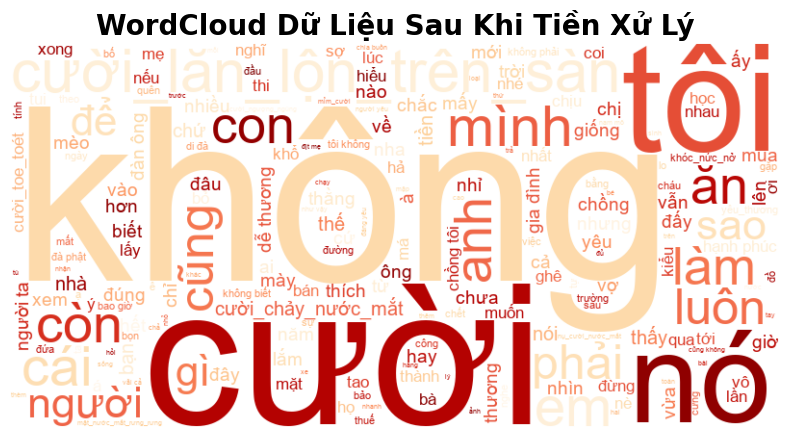

In [345]:
preprocessed_hus_fb['Tokenized_Sentence'] = preprocessed_hus_fb['Tokenized_Sentence'].apply(convert_to_list)

# Join lại
all_words = " ".join([" ".join(tokens) if isinstance(tokens, list) else tokens 
                     for tokens in preprocessed_hus_fb['Tokenized_Sentence']])
# Tạo WordCloud
wc = WordCloud(font_path='arial',
               background_color='white',
               width=800, height=400,
               colormap='OrRd').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Dữ Liệu Sau Khi Tiền Xử Lý",
          fontsize=20,
          fontweight='bold')
plt.show()

Nhận xét: Do enjoyment và icon nhiều nên chữ cười có tần suất xuất hiện nhiều nhất 

### Tần suất từ theo từng nhãn

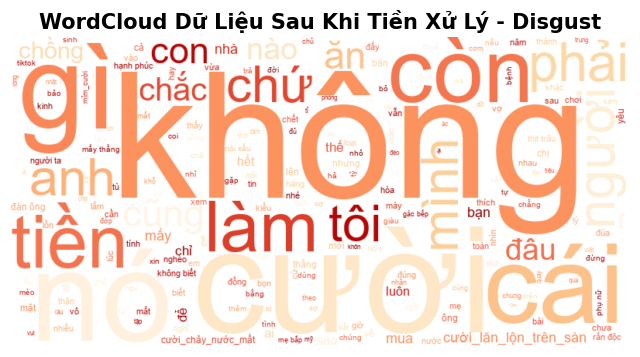

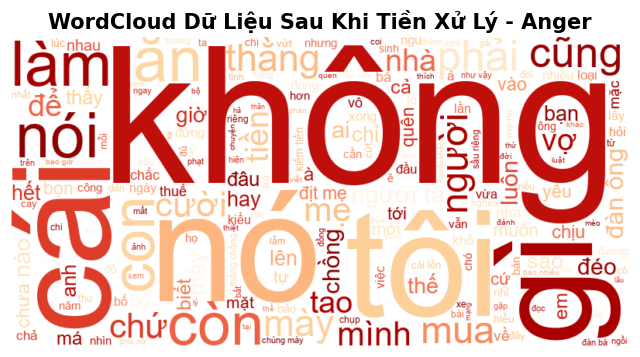

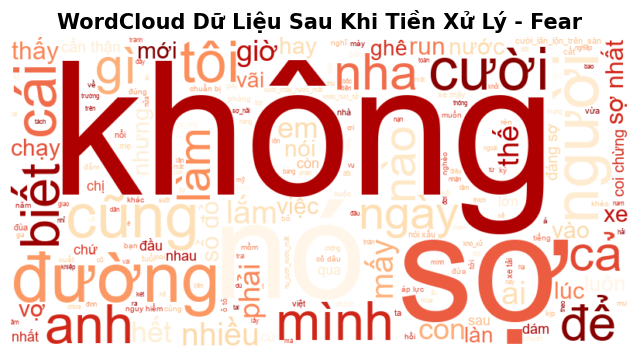

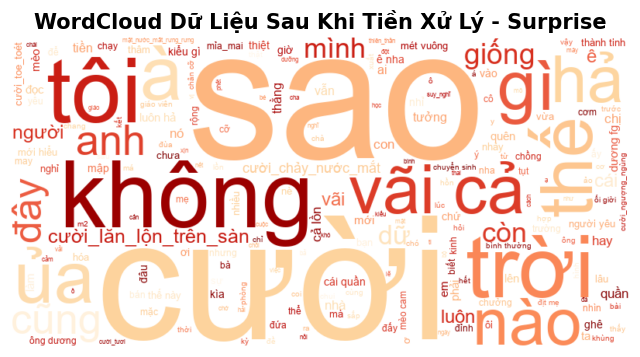

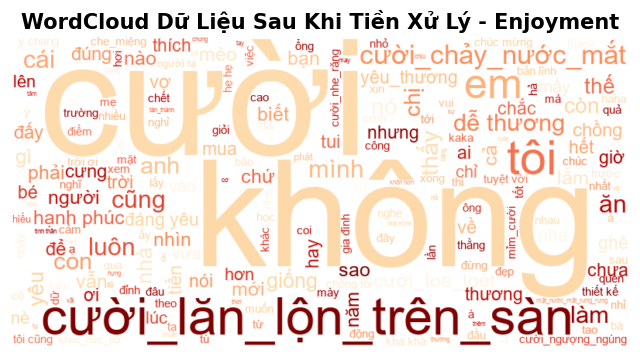

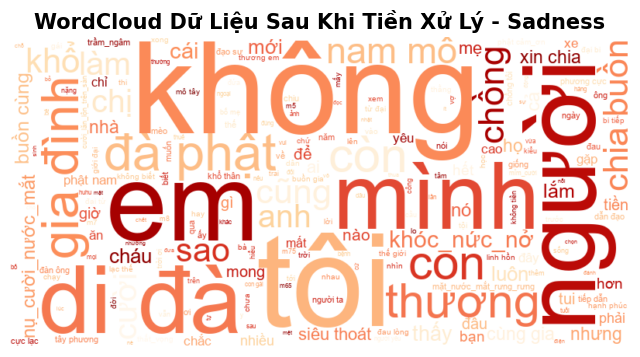

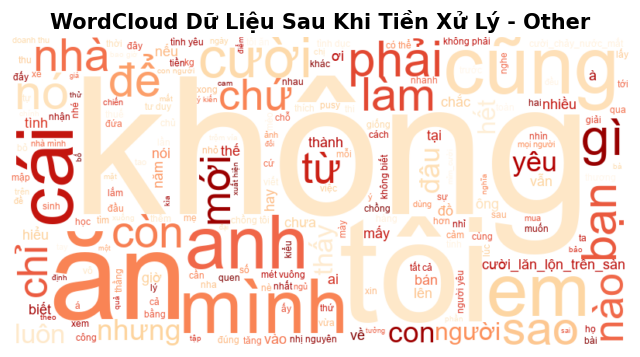

In [346]:
# WordCloud cho từng nhãn cảm xúc
emotions = preprocessed_hus_fb['Emotion'].unique()

for idx, emotion in enumerate(emotions):
    emotion_data = preprocessed_hus_fb[preprocessed_hus_fb['Emotion'] == emotion]
    # Join lại
    all_words = " ".join([" ".join(tokens) if isinstance(tokens, list) else tokens 
                        for tokens in emotion_data['Tokenized_Sentence']])

    # Tạo WordCloud
    wc = WordCloud(font_path='arial',
                background_color='white',
                width=800, height=400,
                colormap='OrRd').generate(all_words)

    plt.figure(figsize=(8, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud Dữ Liệu Sau Khi Tiền Xử Lý - {emotion}",
            fontsize=15,
            fontweight='bold')
    plt.show()

### Phân bố số lượng token theo từng nhãn

--- THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN ---
            count       mean        std  min  25%  50%   75%    max
Emotion                                                            
Anger       428.0  14.450935  18.088125  1.0  5.0  9.0  17.0  215.0
Disgust     616.0  10.243506  11.203765  1.0  5.0  8.0  12.0  181.0
Enjoyment  1756.0   7.034169   8.644282  1.0  3.0  5.0   8.0  197.0
Fear        123.0   8.934959   8.587772  1.0  4.0  6.0  10.5   53.0
Other       860.0   8.893023  11.563771  1.0  4.0  6.0  10.0  138.0
Sadness     445.0  10.395506  13.726445  1.0  4.0  7.0  12.0  175.0
Surprise    293.0   5.218430   3.674244  1.0  3.0  4.0   6.0   31.0


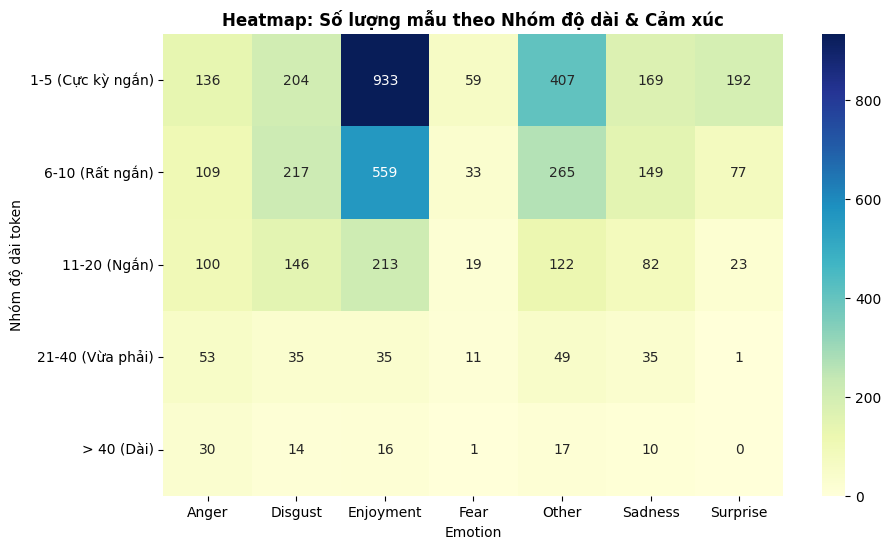

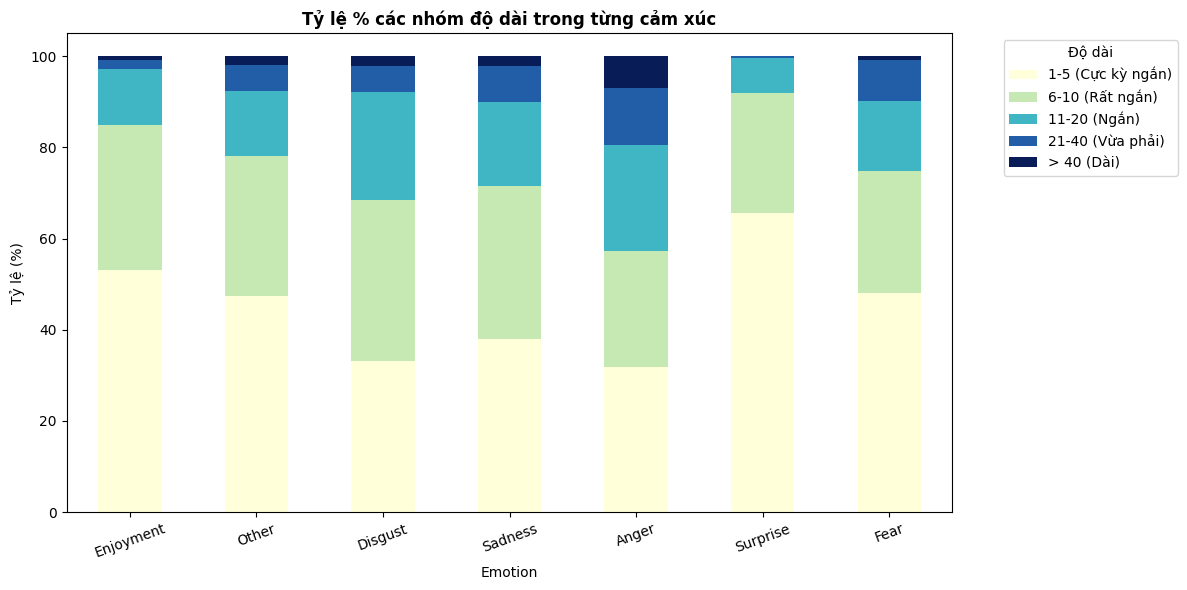

In [347]:
df = preprocessed_hus_fb.copy()

# Lấy thứ tự nhãn theo số lượng
order_by_count = df['Emotion'].value_counts().index

# ==========================================
# BẢNG THỐNG KÊ CHI TIẾT (Describe)
# ==========================================
print("--- THỐNG KÊ ĐỘ DÀI TOKEN THEO NHÃN ---")
stats = df.groupby('Emotion')['tokens_length'].describe()
print(stats)

# ==========================================
# PHÂN NHÓM ĐỘ DÀI - 5 nhóm từ Cực kỳ ngắn đến Rất dài
# ==========================================
# Định nghĩa các khoảng (bins) và nhãn (labels)
bins = [0, 5, 10, 20, 40, 1000]
labels = ['1-5 (Cực kỳ ngắn)', '6-10 (Rất ngắn)', '11-20 (Ngắn)', '21-40 (Vừa phải)', '> 40 (Dài)']

# Tạo cột nhóm độ dài
df['len_group'] = pd.cut(df['tokens_length'], bins=bins, labels=labels)

# Tính toán bảng Pivot: Đếm số lượng emotion trong từng nhóm độ dài
pivot_table = pd.crosstab(df['len_group'], df['Emotion'])

# Vẽ biểu đồ Heatmap để nhìn độ tập trung
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap: Số lượng mẫu theo Nhóm độ dài & Cảm xúc', fontweight='bold')
plt.xlabel('Emotion')
plt.ylabel('Nhóm độ dài token')
plt.show()

# Vẽ biểu đồ Stacked Bar để xem tỷ lệ %
pivot_percent = pd.crosstab(df['Emotion'], df['len_group'], normalize='index') * 100
pivot_percent = pivot_percent.loc[order_by_count] # Sắp xếp lại thứ tự

pivot_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='YlGnBu')
plt.title('Tỷ lệ % các nhóm độ dài trong từng cảm xúc', fontweight='bold')
plt.ylabel('Tỷ lệ (%)')
plt.xlabel('Emotion')
plt.legend(title='Độ dài', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

### Phân tích từ vựng: N-grams và TF-IDF keywords

#### N-grams: Bigram & Trigram


Phân tích cho nhãn: Disgust


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


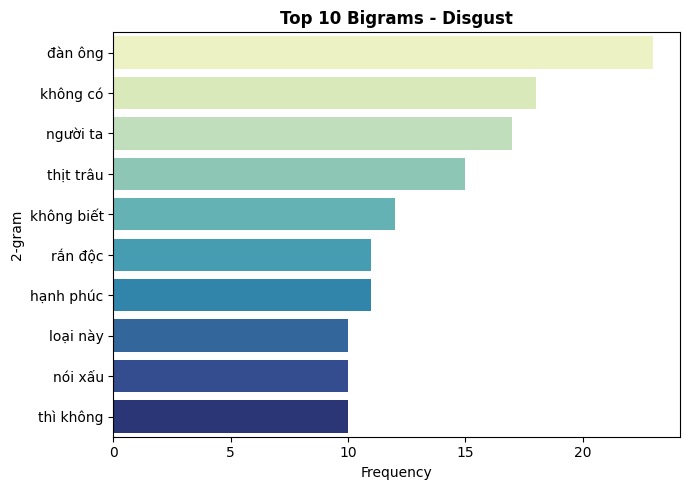

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


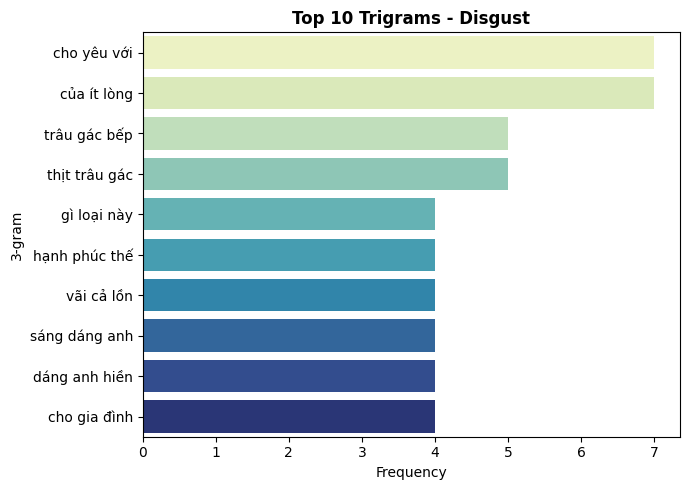


Phân tích cho nhãn: Anger


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


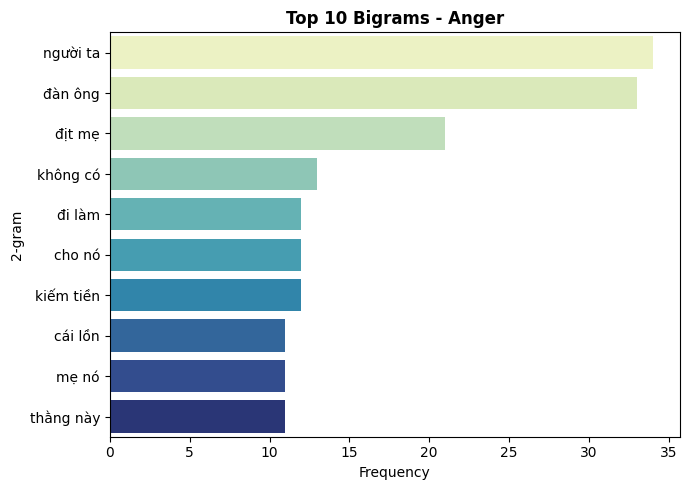

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


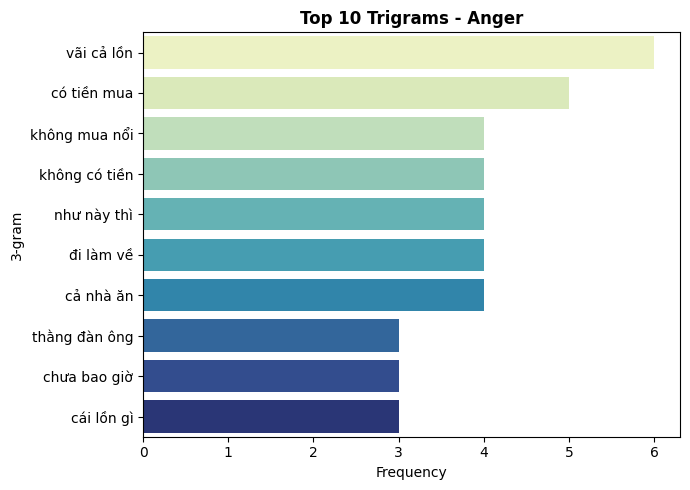


Phân tích cho nhãn: Fear


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


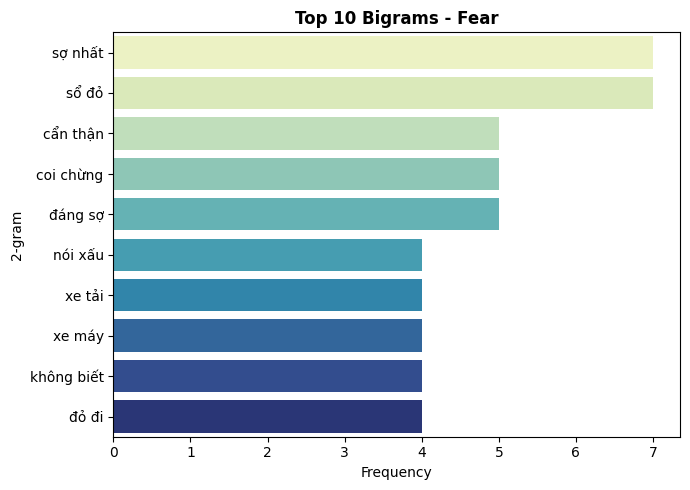

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


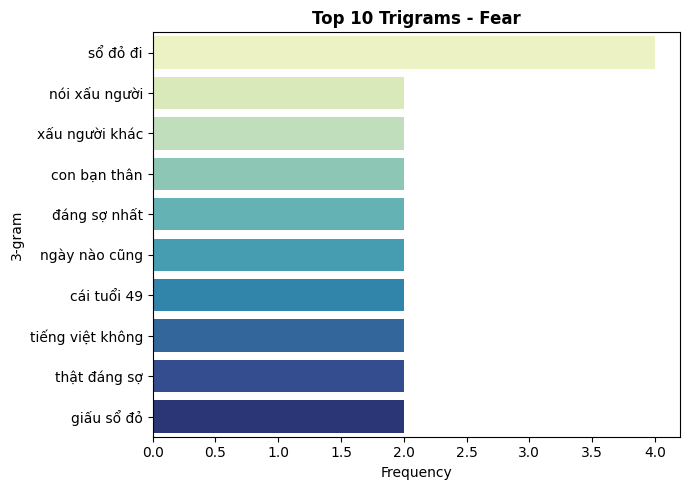


Phân tích cho nhãn: Surprise


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


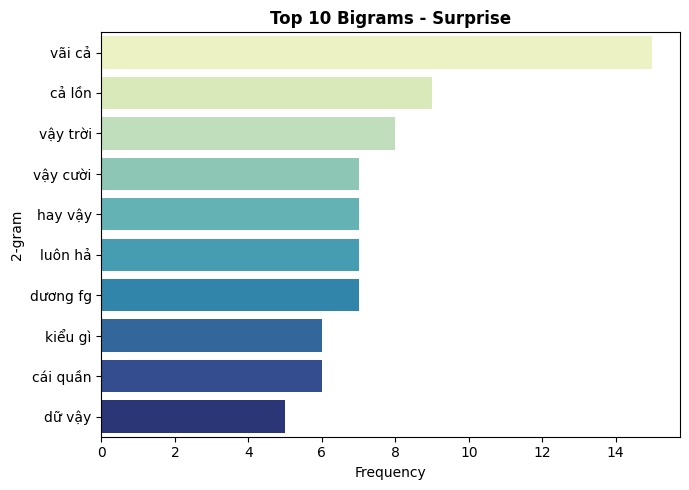

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


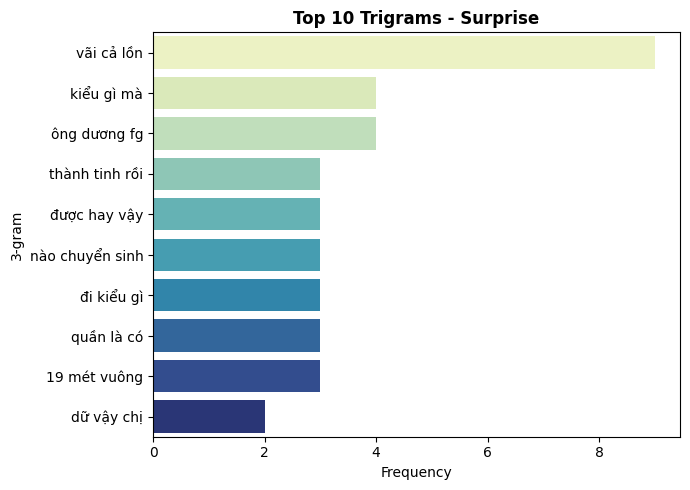


Phân tích cho nhãn: Enjoyment


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


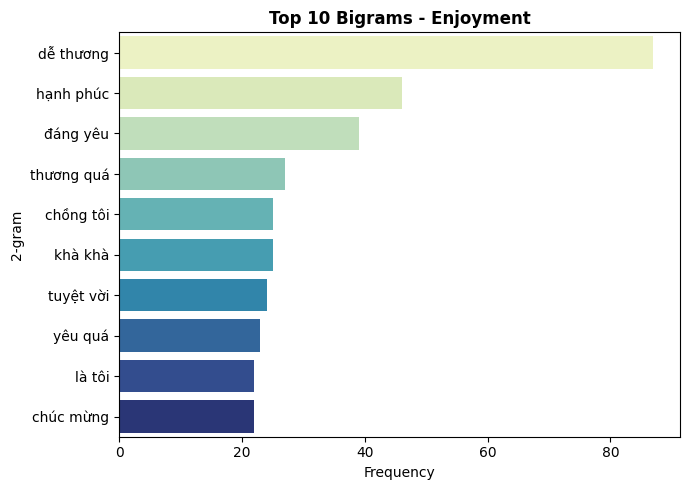

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


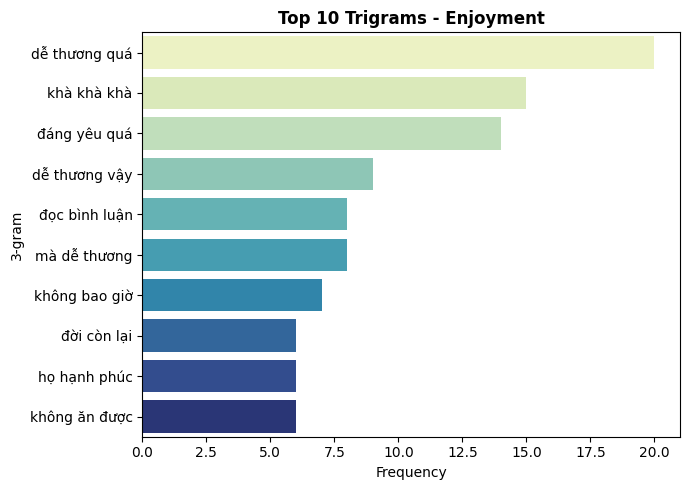


Phân tích cho nhãn: Sadness


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


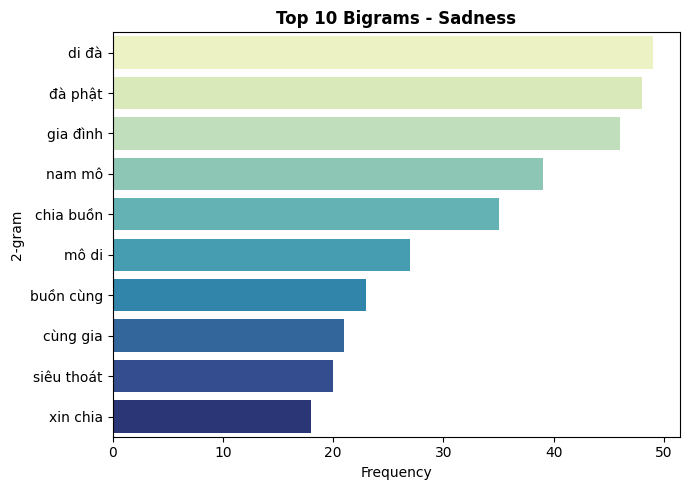

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


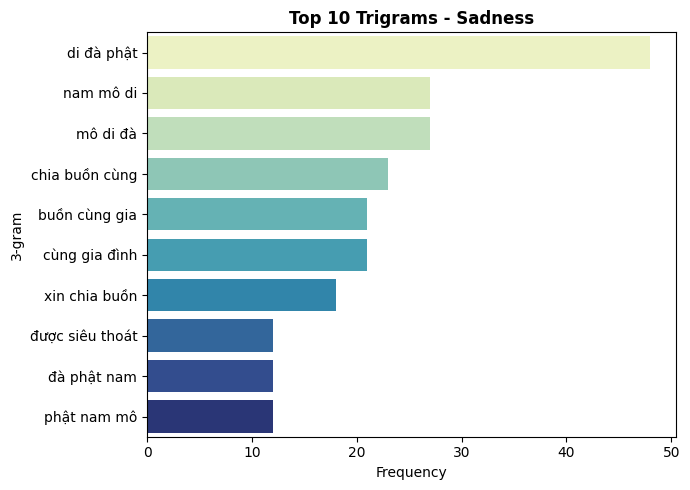


Phân tích cho nhãn: Other


C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


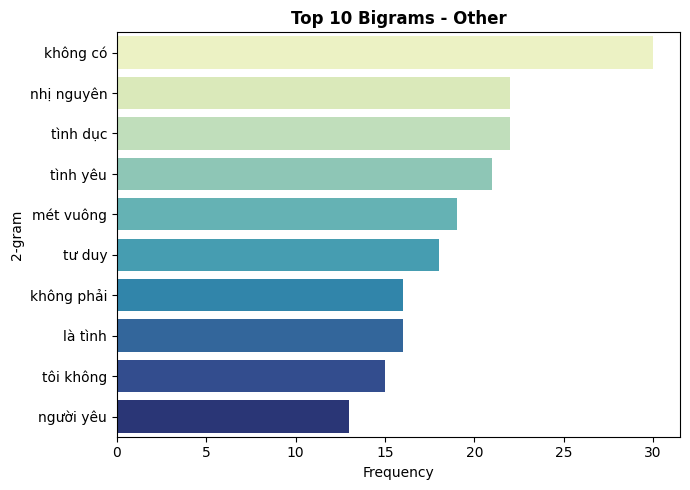

C:\Users\Admin\AppData\Local\Temp\ipykernel_14364\440105247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngram, palette='YlGnBu')


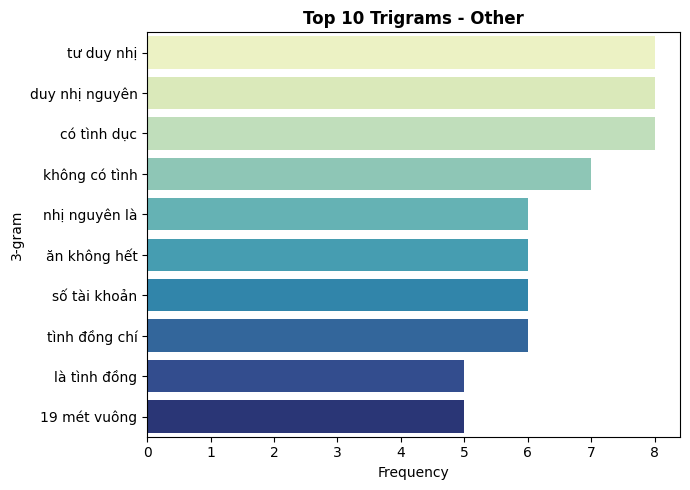

In [348]:
# chạy vòng lặp cho tất cả các nhãn
labels_to_check = df['Emotion'].unique() # đã có bảng df ở trên phần phân bố token

for label in labels_to_check:
    print(f"\nPhân tích cho nhãn: {label}")
    subset = df[df['Emotion'] == label]['Sentence'] # Thay 'Sentence' bằng tên cột văn bản đã xử lý của bạn
    
    # 1. Vẽ Bigram (2 từ)
    plot_top_ngrams(subset, n=2, top_k=10, title=f"Top 10 Bigrams - {label}")
    
    # 2. Vẽ Trigram (3 từ)
    plot_top_ngrams(subset, n=3, top_k=10, title=f"Top 10 Trigrams - {label}")

#### TF-IDF keysword

In [349]:
# 1. Gộp văn bản theo từng nhóm Emotion
grouped_df = df.groupby('Emotion')['Sentence'].apply(lambda x: ' '.join(x)).reset_index()

# 2. Tính TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000) # Thử cả unigram và bigram
tfidf_matrix = tfidf.fit_transform(grouped_df['Sentence'])
feature_names = tfidf.get_feature_names_out()

In [350]:
print("--- TOP TỪ KHÓA ĐẶC TRƯNG (TF-IDF) CHO TỪNG NHÃN ---")
for idx, row in grouped_df.iterrows():
    emotion = row['Emotion']
    keywords = get_top_tfidf_keywords(idx, top_n=5)
    print(f"\nLabel: {emotion.upper()}")
    for kw, score in keywords:
        print(f"  - {kw}: {score:.4f}")

--- TOP TỪ KHÓA ĐẶC TRƯNG (TF-IDF) CHO TỪNG NHÃN ---

Label: ANGER
  - không: 0.2830
  - thì: 0.2320
  - nó: 0.1951
  - cho: 0.1846
  - mà: 0.1811

Label: DISGUST
  - không: 0.3224
  - là: 0.2298
  - thì: 0.2242
  - này: 0.2149
  - cười: 0.2020

Label: ENJOYMENT
  - cười: 0.3065
  - không: 0.2715
  - tôi: 0.2338
  - cười_lăn_lộn_trên_sàn: 0.2246
  - là: 0.1960

Label: FEAR
  - không: 0.3444
  - sợ: 0.3346
  - đi: 0.2067
  - đường: 0.1785
  - nó: 0.1771

Label: OTHER
  - không: 0.4154
  - là: 0.2861
  - có: 0.2498
  - tôi: 0.2324
  - thì: 0.1874

Label: SADNESS
  - di đà: 0.2339
  - di: 0.2339
  - đà phật: 0.2291
  - không: 0.2240
  - tôi: 0.2140

Label: SURPRISE
  - vậy: 0.3650
  - sao: 0.2351
  - mà: 0.2103
  - cười: 0.2041
  - là: 0.1794
